In [27]:
!git clone https://www.github.com/genekogan/neural-style-pt
%cd neural-style-pt
!git checkout modular
!pip install ninja
!python models/download_models.py

Cloning into 'neural-style-pt'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 536 (delta 0), reused 1 (delta 0), pack-reused 531
Receiving objects: 100% (536/536), 36.84 MiB | 40.43 MiB/s, done.
Resolving deltas: 100% (275/275), done.
/content/neural-style-pt
Branch 'modular' set up to track remote branch 'modular' from 'origin'.
Switched to a new branch 'modular'
All models have been successfully downloaded


In [28]:
from model import *
from utils import *
import torch
import torchvision.transforms as transforms
from PIL import Image
import requests
from io import BytesIO
from imageio import imread


def optimize(stylenet, img, num_iterations, output_path, original_colors, print_iter=None, save_iter=None):
    def iterate():
        t[0] += 1
    
        optimizer.zero_grad()
        stylenet(img)
        loss = stylenet.get_loss()
        loss.backward()
        
        maybe_print(stylenet, t[0], print_iter, num_iterations, loss)
        maybe_save(img, t[0], save_iter, num_iterations, original_colors, output_path)

        return loss
    
    img = nn.Parameter(img.type(stylenet.dtype))
    optimizer, loopVal = setup_optimizer(img, stylenet.params, num_iterations)
    t = [0]
    while t[0] <= loopVal:
        optimizer.step(iterate)
    
    return img


def preprocess_from_url(image, image_size, to_normalize=True):
    if type(image_size) is not tuple:
        image_size = tuple([int((float(image_size) / max(image.size))*x) for x in (image.height, image.width)])
    Loader = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
    rgb2bgr = transforms.Compose([transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])])])
    if to_normalize:
        Normalize = transforms.Compose([transforms.Normalize(mean=[103.939, 116.779, 123.68], std=[1,1,1])])
        tensor = Normalize(rgb2bgr(Loader(image) * 256)).unsqueeze(0)
    else:
        tensor = rgb2bgr(Loader(image)).unsqueeze(0)
    return tensor


def load_image_url(url, image_size, to_normalize=True):
  image = Image.fromarray(imread(url)).convert('RGB')
  return preprocess_from_url(image, image_size, to_normalize)


# setup stylenet
params = StylenetArgs()
params.gpu = '0'
params.backend = 'cudnn'

dtype, multidevice, backward_device = setup_gpu(params)
stylenet = StyleNet(params, dtype, multidevice, backward_device)

VGG-19 Architecture Detected
Successfully loaded models/vgg19-d01eb7cb.pth
conv1_1: 64 3 3 3
conv1_2: 64 64 3 3
conv2_1: 128 64 3 3
conv2_2: 128 128 3 3
conv3_1: 256 128 3 3
conv3_2: 256 256 3 3
conv3_3: 256 256 3 3
conv3_4: 256 256 3 3
conv4_1: 512 256 3 3
conv4_2: 512 512 3 3
conv4_3: 512 512 3 3
conv4_4: 512 512 3 3
conv5_1: 512 512 3 3
conv5_2: 512 512 3 3
conv5_3: 512 512 3 3
conv5_4: 512 512 3 3
Setting up style layer 2: relu1_1
Setting up style layer 7: relu2_1
Setting up histogram layer 7: relu2_1
Setting up style layer 12: relu3_1
Setting up histogram layer 12: relu3_1
Setting up style layer 21: relu4_1
Setting up histogram layer 21: relu4_1
Setting up content layer 23: relu4_2
Setting up style layer 30: relu5_1
Setting up histogram layer 30: relu5_1
Sequential(
  (0): TVLoss()
  (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): ReLU(inplace=True)
  (3): MaskedStyleLoss(
    (crit): MSELoss()
    (gram): GramMatrix()
  )
  (4): Conv2d(64, 64, kernel_

In [0]:
import os

content_list = os.listdir('../images')
style_list = os.listdir('../styles')

In [0]:
import random

content_img = random.choice(content_list)
content_img = '../images/' + content_img

style_img = random.choice(style_list)
style_img = '../styles/' + style_img

In [32]:
content_img

'../images/Girl008.png'

Iteration 1000/1000: 
  Style loss = 5.0e+02, 3.9e+04, 5.5e+04, 1.3e+05, 3.4e+03
  Histogram loss = 
  TV loss = 7.8e+04
  Total loss = 3.05e+05


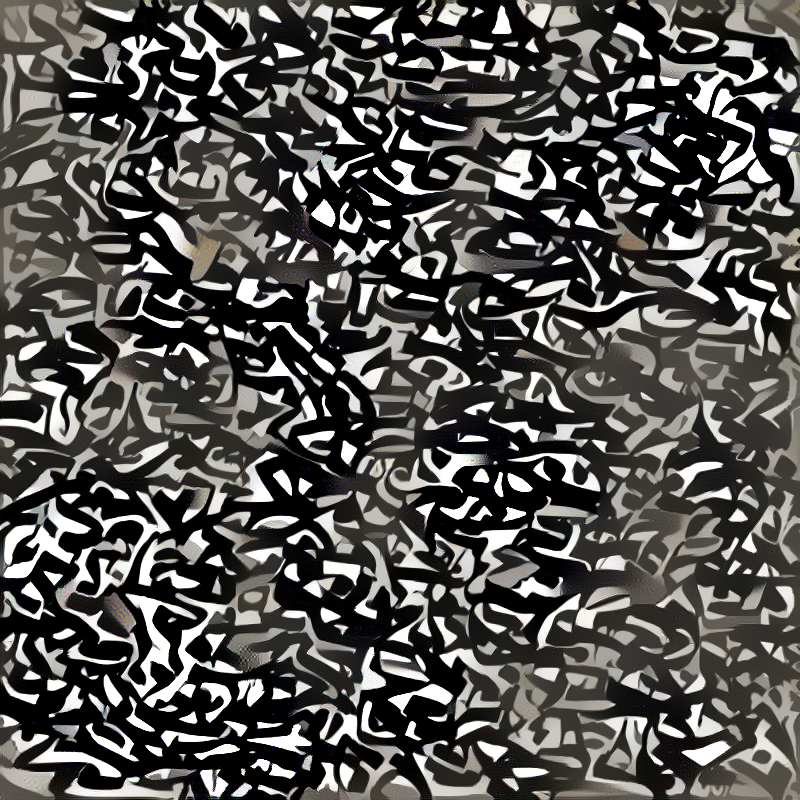

In [44]:
content_path = content_img
style_paths = [style_img]

#content_path = style_img
#style_paths = [content_img]

num_iterations = 1000
output_path = 'out.png'
image_size = 800
original_colors = 0
style_scale = 0.8
print_iter = 100
save_iter = 100


# load content image
content_image = load_image_url(content_path, image_size)

# load style images
style_size = int(image_size * style_scale)
style_images = [load_image_url(path, style_size) for path in style_paths]

# set hyper-parameters
stylenet.set_content_weight(0)
stylenet.set_style_weight(2e2)
stylenet.set_hist_weight(0)
stylenet.set_tv_weight(1e-3)
stylenet.set_style_statistic('gram')

# capture the style and content images
stylenet.capture(content_image, style_images)

# initialize with a random image
img = random_image_like(content_image)

# optimize!
img = optimize(stylenet, img, num_iterations, output_path, original_colors, print_iter, save_iter)

# display
deprocess(img)

In [0]:
img = Image.open(content_img)
img = img.convert("RGBA")
datas = img.getdata()

img_colors = []
colors_dict = {}

for item in datas:
    if item not in img_colors:
        img_colors.append(item)
        colors_dict.update( {item : 1} )
    else:
        colors_dict[item] += 1


import operator

#color_mx = max(colors_dict.iteritems(), key=operator.itemgetter(1))[0]
color_mx = max(colors_dict.items(), key=operator.itemgetter(1))[0]

In [0]:
img = Image.open('out.png')
img = img.convert("RGBA")
datas = img.getdata()

newData = []
for item in datas:
    if item[0] not in range(0,100) and item[1] not in range(0,100) and item[2] not in range(0,100):
        newData.append(color_mx)
    else:
        #if item[0] > 150:
        #    newData.append((0, 0, 0, 255))
        #else:
        #    newData.append(item)
        newData.append(item)


img.putdata(newData)
img.save("out.png", "PNG")

In [0]:
img = Image.open(content_img)
img = img.convert("RGBA")
datas = img.getdata()

newData = []
for item in datas:
    if item[0] == color_mx[0] and item[1] == color_mx[1] and item[2] == color_mx[2]:
        newData.append((255, 255, 255, 0))
    else:
        #if item[0] > 150:
        #    newData.append((0, 0, 0, 255))
        #else:
        #    newData.append(item)
        newData.append(item)


img.putdata(newData)
img.save("../images/transparentGirlImg.png", "PNG")

In [0]:
## Pasting restyled image to the background of the transparent original image

background = Image.open("out.png").convert("RGBA")
foreground = Image.open("../images/transparentGirlImg.png")

#temp_img = Image.blend(background, background, .7)

final_output = Image.new("RGBA", background.size)
final_output.paste(background, (0,0), background)
final_output.paste(foreground, (0,0), foreground)

final_output.save("../output/blended.png")